In [150]:

%matplotlib inline     

import re
from adjustText import adjust_text

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# NB: must be *before* importing matplotlib.pyplot
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})
plt.ioff()                    # we'll display the figure manually as a widget

import sys, json, yaml, pickle, logging, numpy as np
import plotly.graph_objects as go
from ipywidgets import Dropdown, IntRangeSlider, FloatSlider, Label, VBox, HBox, Output, Button
from IPython.display import display

# ----------------------------------------------------------------------------- 
# 1.  Module-import PATHS (unchanged)
pkg_root = "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

# --- Your pipeline’s imports (unchanged) -------------------------------------
from scint_analysis import config, pipeline, plotting
from scint_analysis.analysis import lorentzian_component, gaussian_component
from scint_analysis.core import ACF
from scint_analysis.config import update_fitting_parameter, update_pipeline_parameter, update_yaml_guesses, update_yaml_config

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

In [151]:
# --- Physical and Astronomical Constants (SI Units) ---
C_LIGHT = 299792458.0  # Speed of light in m/s
PC_TO_M = 3.0857e16     # Parsecs to meters
KPC_TO_M = PC_TO_M * 1000

# --- Define the Planck 2018 Cosmology ---
# Using parameters from Planck Collaboration et al. (2018)
cosmo_planck18 = FlatLambdaCDM(H0=67.4, Om0=0.315)

# Function to extract NE2001 prediction
def extract_ne2001(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'gamma:\s*([\d.]+)', text)
    if match:
        return float(match.group(1))
    return np.nan

# Function to parse tau error strings
def parse_tau_error(tau_err_str):
    """Parse error strings like '(+0.012, -0.002)' """
    if pd.isna(tau_err_str) or tau_err_str == '':
        return np.nan, np.nan
    
    match = re.search(r'\+?([\d.]+).*?-([\d.]+)', str(tau_err_str))
    if match:
        err_plus = float(match.group(1))
        err_minus = float(match.group(2))
        return err_plus, err_minus
    return np.nan, np.nan


def check_fourier_consistency(tau_s, nu_s, C_factor_range=(0.5, 2.0)):
    """
    Checks if scattering time and scintillation bandwidth are consistent with
    originating from the same screen via the Fourier uncertainty principle.

    Args:
        tau_s (float): The pulse broadening timescale in seconds.
        nu_s (float): The decorrelation bandwidth in Hertz.
        C_factor_range (tuple): The expected range for the constant C in the
                                relation 2 * pi * tau_s * nu_s = C[cite: 1128].

    Returns:
        tuple: A tuple containing the calculated C value and a boolean
               indicating if it falls within the expected range.
    """
    calculated_c = 2 * np.pi * tau_s * nu_s
    is_consistent = C_factor_range[0] <= calculated_c <= C_factor_range[1]
    return calculated_c, is_consistent


def estimate_host_screen_distance(redshift, nu_obs_hz, nu_s_mw_hz, tau_s_host_s, d_mw_m, m_mw=1.0):
    """
    Estimates the distance between an FRB and the screen in its host galaxy
    using the Planck 2018 cosmology.

    This function implements the formula from Pradeep et al. (2025),
    which provides an upper limit based on the coherence condition between two screens.
    It assumes the screens are isotropic and two-dimensional.

    Args:
        redshift (float): The spectroscopic redshift of the FRB host galaxy.
        nu_obs_hz (float): The reference observing frequency for the measurements (in Hz).
        nu_s_mw_hz (float): The scintillation bandwidth of the Milky Way screen (in Hz).
        tau_s_host_s (float): The scattering timescale from the host screen (in s).
        d_mw_m (float): The estimated distance to the Milky Way screen (in meters).
        m_mw (float): The modulation index of the MW scintillation. A value < 1 indicates
                      a resolved system. Defaults to 1.0.

    Returns:
        float: The estimated upper limit on the distance between the FRB and the
               host galaxy screen (d_h,FRB) in parsecs.
    """
    # Calculate the angular diameter distance to the FRB using the defined cosmology
    d_frb_m = cosmo_planck18.angular_diameter_distance(redshift).to(u.m).value

    # The Pradeep et al. formula:
    # D_h,FRB * D_MW <= (1+z)*D_FRB^2 / (8*pi*nu^2) * nu_s,MW / (m_MW*tau_s,h)
    numerator = (1 + redshift) * d_frb_m**2 * nu_s_mw_hz
    denominator = 8 * np.pi * nu_obs_hz**2 * m_mw * tau_s_host_s
    
    d_h_d_mw_product_m2 = numerator / denominator
    
    # Solve for the host screen distance
    d_h_frb_m = d_h_d_mw_product_m2 / d_mw_m

    # Convert the final result from meters to parsecs
    d_h_frb_pc = d_h_frb_m / PC_TO_M

    return d_h_frb_pc

['FRB 20220207C', 'FRB 20220310F', 'FRB 20220506D', 'FRB 20221113A', 'FRB 20221203A', 'FRB 20230307A', 'FRB 20230325A', 'FRB 20230913A ', 'FRB 20240119A', 'FRB 20240203A', 'FRB 20240229A', 'FRB 20230814B']
[0.043  0.479  0.3005 0.2505 0.51   0.271     nan 0.3024    nan 0.074
 0.287     nan]
[0.276 0.151 0.831 0.284 0.307 0.568 0.143 0.243 0.208 0.13  0.023 0.156]
[0.012 0.017 0.089 0.013 0.049 0.126 0.01  0.135 0.122 0.012 0.204 0.076]
[0.002 0.01  0.077 0.013 0.136 0.228 0.007 0.14  0.03  0.004 0.004 0.012]
[0.77815463 2.62542063 0.61313219 0.49776777 0.62975428 4.11778521
 1.09128728 0.80870542 0.14646076 0.77603436 4.07304557 0.35807856]
[0.730525      nan 0.42225  0.5954   0.12105  4.253    1.05345  0.5372
 0.33955  1.576    0.6367   7.6315  ]
[ True  True  True  True  True  True  True  True  True  True  True  True]


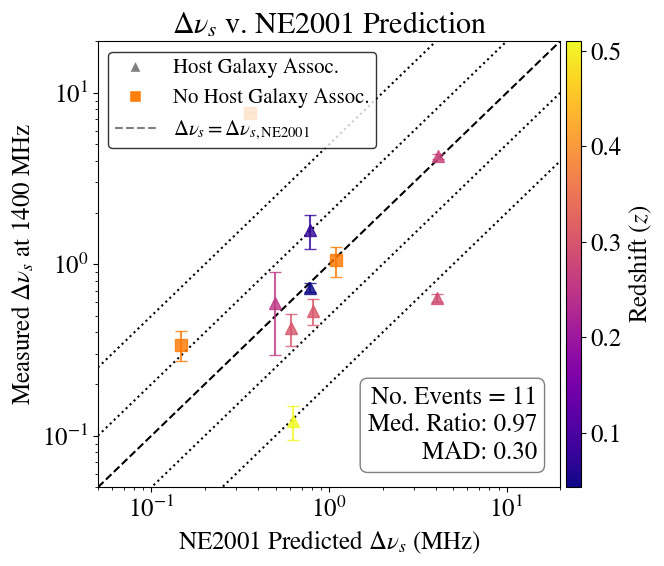

In [155]:
# --- Data Loading and Parsing ---
# Read the CSV file
df = pd.read_csv('DSA_CHIME_BurstProps.csv')

# Process the data for two-screen analysis
frb_names = []
redshifts = []
tau_1ghz_values = []
tau_errors_plus = []
tau_errors_minus = []
ne2001_bw_mhz = []
measured_bw_mhz = []
measured_bw_mhz_err = []
has_localization = []

for _, row in df.iterrows():
    frb_name = row['TNS']
    frb_names.append(row['TNS'])
    try:
        redshifts.append(float(row['Redshift']))
    except ValueError:
        redshifts.append(np.nan)
    
    # Extract tau at 1 GHz
    tau_1ghz_values.append(row['Tau_1GHz_ms'])
    
    # Parse tau errors
    err_plus, err_minus = parse_tau_error(row['Tau_1GHz_err_ms'])
    tau_errors_plus.append(err_plus)
    tau_errors_minus.append(err_minus)
    
    # Extract NE2001 bandwidth
    ne2001_bw_mhz.append(row['Gamma_1.4GHz_NE2001_MHz'])
    
    # Extract measured bandwidths and average
    try:
        measured_bw_mhz.append(float(row['Gamma_1.4GHz_MHz']))
        measured_bw_mhz_err.append(float(row['Gamma_1.4GHz_err_MHz']))
    except ValueError:
        # If the column doesn't exist, append NaN
        measured_bw_mhz.append(np.nan)
        measured_bw_mhz_err.append(np.nan)
    
    # Check localization
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')

# Convert to arrays
redshifts = np.array(redshifts)
tau_1ghz_values = np.array(tau_1ghz_values)
tau_errors_plus = np.array(tau_errors_plus)
tau_errors_minus = np.array(tau_errors_minus)
ne2001_bw_mhz = np.array(ne2001_bw_mhz)
measured_bw_mhz = np.array(measured_bw_mhz)
has_localization = np.array(has_localization)

print(frb_names)
print(redshifts)
print(tau_1ghz_values)
print(tau_errors_plus)
print(tau_errors_minus)
print(ne2001_bw_mhz)
print(measured_bw_mhz)
print(has_localization)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(7, 6))

# Plot limits and equality/factor lines
plot_min, plot_max = 0.05, 20
ax.set_xlim(plot_min, plot_max)
ax.set_ylim(plot_min, plot_max)
x_line = np.logspace(np.log10(plot_min), np.log10(plot_max), 100)
ax.plot(x_line, x_line, 'k--')#, alpha=0.5)
ax.plot(x_line, 2*x_line, 'k:')#, alpha=0.3)
ax.plot(x_line, x_line/2, 'k:')#, alpha=0.3)
ax.plot(x_line, 5*x_line, 'k:')#, alpha=0.15)
ax.plot(x_line, x_line/5, 'k:')#, alpha=0.15)

# --- Redshift Colormap Setup ---
# Create a colormap for localized bursts based on their redshift
valid_redshifts = redshifts[has_localization & ~np.isnan(redshifts)]
if len(valid_redshifts) > 0:
    norm = colors.Normalize(vmin=np.min(valid_redshifts), vmax=np.max(valid_redshifts))
    cmap = cm.plasma
else: # Fallback if no valid redshifts
    norm = colors.Normalize(vmin=0.2, vmax=0.8)
    cmap = cm.plasma

# Plot data points and collect text labels
texts = []
for i in range(len(tns_names)):
    # Determine marker and color based on localization status
    if has_localization[i] and not np.isnan(redshifts[i]):
        marker = '^'
        point_color = cmap(norm(redshifts[i]))
    else:
        marker = 's'
        point_color = "#ff7700" # Orange for non-localized
        
    ax.errorbar(ne2001_bw_mhz[i], measured_bw_mhz[i], 
                yerr=measured_bw_mhz_err[i], 
                fmt=marker, color=point_color, 
                markersize=8, capsize=4, alpha=0.8, ecolor=point_color)
    
    # Add labels to a list for later adjustment
    #short_name = tns_names[i].replace('FRB ', '')
    #texts.append(ax.text(ne2001_predictions[i], measured_gammas[i], short_name)) #, #fontsize=8, alpha=0.9))

# --- Automatic Label Adjustment ---
if texts:
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5, alpha=0.5))

# Axes settings
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('NE2001 Predicted $\Delta\\nu_{s}$ (MHz)') #, fontsize=14)
ax.set_ylabel('Measured $\Delta\\nu_{s}$ at 1400 MHz')#, fontsize=14)
ax.set_title('$\\Delta\\nu_{s}$ v. NE2001 Prediction')#, fontsize=16)

# --- Updated Legend and Colorbar ---
legend_elements = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', 
           markersize=8, label='Host Galaxy Assoc.'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#ff7f0e', 
           markersize=8, label='No Host Galaxy Assoc.'),
    Line2D([0], [0], color='k', linestyle='--', alpha=0.5, label='$\Delta\\nu_{s} = \Delta\\nu_{s,\mathregular{NE2001}}$'),
]
ax.legend(loc='upper left', frameon=True,          # draw the legend patch
        handles=legend_elements,
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize='small')

# Add colorbar for redshift
if len(valid_redshifts) > 0:
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.01, aspect=30)
    cbar.set_label('Redshift ($z$)') #fontsize=12)

# Statistics Box
valid_mask = ~np.isnan(measured_bw_mhz) & ~np.isnan(ne2001_bw_mhz)
if np.sum(valid_mask) > 0:
    ratios = measured_bw_mhz[valid_mask] / ne2001_bw_mhz[valid_mask]
    median_ratio = np.median(ratios)
    mad_ratio = np.median(np.abs(ratios - median_ratio))
    
    textstr = f'No. Events = {np.sum(valid_mask)}\n'
    textstr += f'Med. Ratio: {median_ratio:.2f}\n'
    textstr += f'MAD: {mad_ratio:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes, #fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()


['FRB 20220207C', 'FRB 20220310F', 'FRB 20220506D', 'FRB 20221113A', 'FRB 20221203A', 'FRB 20230307A', 'FRB 20230325A', 'FRB 20230913A ', 'FRB 20240119A', 'FRB 20240203A', 'FRB 20240229A', 'FRB 20230814B']
[0.043  0.479  0.3005 0.2505 0.51   0.271     nan 0.3024    nan 0.074
 0.287     nan]
[0.276 0.151 0.831 0.284 0.307 0.568 0.143 0.243 0.208 0.13  0.023 0.156]
[0.012 0.017 0.089 0.013 0.049 0.126 0.01  0.135 0.122 0.012 0.204 0.076]
[0.002 0.01  0.077 0.013 0.136 0.228 0.007 0.14  0.03  0.004 0.004 0.012]
[0.77815463 2.62542063 0.61313219 0.49776777 0.62975428 4.11778521
 1.09128728 0.80870542 0.14646076 0.77603436 4.07304557 0.35807856]
[0.730525      nan 0.42225  0.5954   0.12105  4.253    1.05345  0.5372
 0.33955  1.576    0.6367   7.6315  ]
[ True  True  True  True  True  True  True  True  True  True  True  True]
d_host: 1846.1159073845445 kpc for FRB FRB 20220207C at z=0.043
d_host: 843723.1367985049 kpc for FRB FRB 20220310F at z=0.479
d_host: 12162.848334799592 kpc for FRB FR

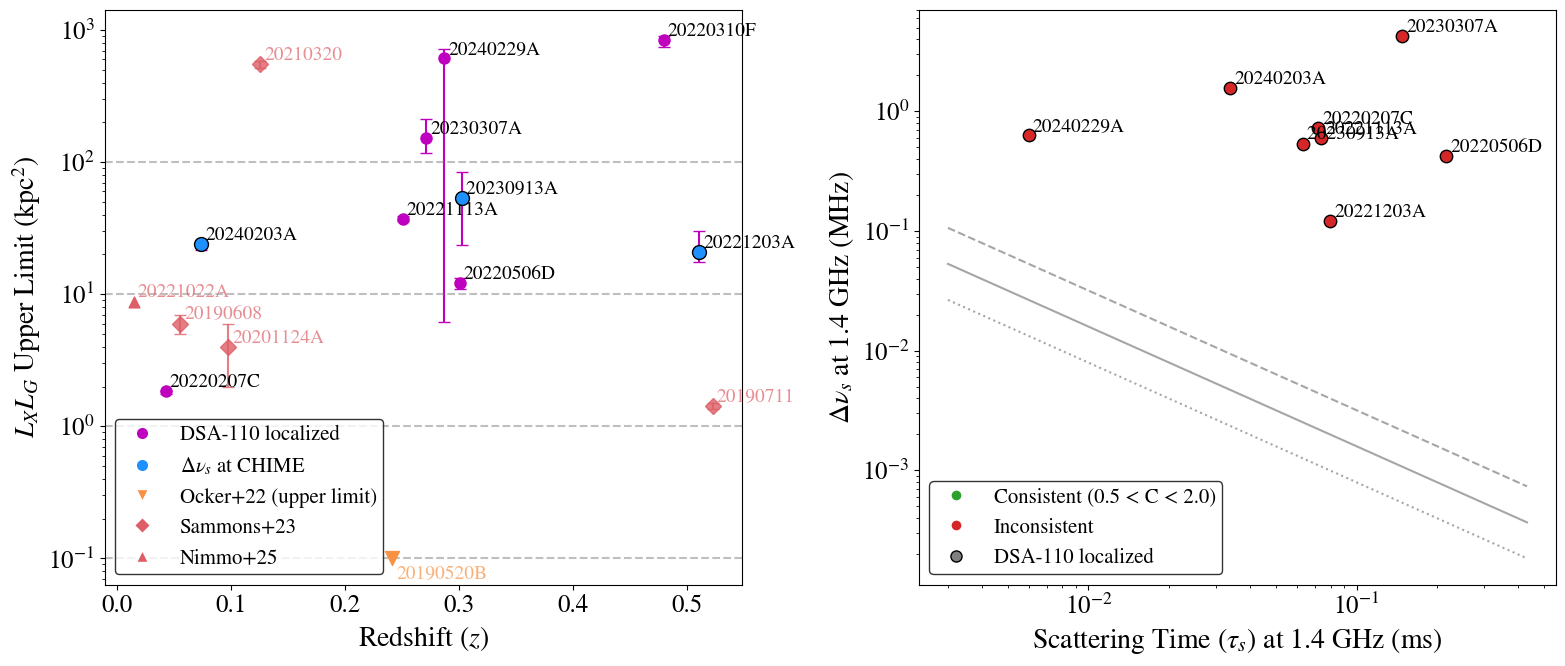


Two-Screen Scattering Analysis Summary:
Total FRBs analyzed: 9

Diagnostic - Non-localized FRBs:

L_X × L_G Upper Limits:
  Median: 37.2 kpc²
  Min: 1.85 kpc²
  Max: 844 kpc²
  < 1 kpc²: 0
  < 10 kpc²: 1
  < 100 kpc²: 6

Fourier Consistency Check:
  Consistent (0.5 < C < 2.0): 0/8
  Mean C value: 720.58

Individual FRB Results:

FRB 20220207C:
  z = 0.043
  τ(1GHz) = 0.28 ms
  L_X × L_G < 1.8 kpc²
  C = 329.77 ✗

FRB 20220310F:
  z = 0.479
  τ(1GHz) = 0.15 ms
  L_X × L_G < 843.7 kpc²

FRB 20220506D:
  z = 0.300
  τ(1GHz) = 0.83 ms
  L_X × L_G < 12.2 kpc²
  C = 573.90 ✗

FRB 20221113A:
  z = 0.251
  τ(1GHz) = 0.28 ms
  L_X × L_G < 37.2 kpc²
  C = 276.56 ✗

FRB 20221203A:
  z = 0.510
  τ(1GHz) = 0.31 ms
  L_X × L_G < 20.9 kpc²
  C = 60.78 ✗

FRB 20230307A:
  z = 0.271
  τ(1GHz) = 0.57 ms
  L_X × L_G < 151.5 kpc²
  C = 3951.04 ✗

FRB 20230913A :
  z = 0.302
  τ(1GHz) = 0.24 ms
  L_X × L_G < 53.5 kpc²
  C = 213.51 ✗

FRB 20240203A:
  z = 0.074
  τ(1GHz) = 0.13 ms
  L_X × L_G < 24.0 kpc²
 

In [157]:
# --- Physical and Astronomical Constants (SI Units) ---
C_LIGHT = 299792458.0  # Speed of light in m/s
PC_TO_M = 3.0857e16     # Parsecs to meters
KPC_TO_M = PC_TO_M * 1000

# --- Define the Planck 2018 Cosmology ---
cosmo_planck18 = FlatLambdaCDM(H0=67.4, Om0=0.315)

# Read the CSV file
df = pd.read_csv('DSA_CHIME_BurstProps.csv')

# Process the data for two-screen analysis
frb_names = []
redshifts = []
tau_1ghz_values = []
tau_errors_plus = []
tau_errors_minus = []
ne2001_bw_mhz = []
measured_bw_mhz = []
has_localization = []

for _, row in df.iterrows():
    frb_name = row['TNS']
    frb_names.append(row['TNS'])
    try:
        redshifts.append(float(row['Redshift']))
    except ValueError:
        redshifts.append(np.nan)
    
    # Extract tau at 1 GHz
    tau_1ghz_values.append(row['Tau_1GHz_ms'])
    
    # Parse tau errors
    err_plus, err_minus = parse_tau_error(row['Tau_1GHz_err_ms'])
    tau_errors_plus.append(err_plus)
    tau_errors_minus.append(err_minus)
    
    # Extract NE2001 bandwidth
    ne2001_bw_mhz.append(row['Gamma_1.4GHz_NE2001_MHz'])
    
    # Extract measured bandwidths and average
    try:
        measured_bw_mhz.append(float(row['Gamma_1.4GHz_MHz']))
    except ValueError:
        # If the column doesn't exist, append NaN
        measured_bw_mhz.append(np.nan)
    
    # Check localization
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')

# Convert to arrays
redshifts = np.array(redshifts)
tau_1ghz_values = np.array(tau_1ghz_values)
tau_errors_plus = np.array(tau_errors_plus)
tau_errors_minus = np.array(tau_errors_minus)
ne2001_bw_mhz = np.array(ne2001_bw_mhz)
measured_bw_mhz = np.array(measured_bw_mhz)
has_localization = np.array(has_localization)

print(frb_names)
print(redshifts)
print(tau_1ghz_values)
print(tau_errors_plus)
print(tau_errors_minus)
print(ne2001_bw_mhz)
print(measured_bw_mhz)
print(has_localization)

# Calculate host screen distances
# Typical MW screen distance: 1 kpc
d_mw_m = 1 * KPC_TO_M
nu_obs_hz = 1.4e9  # 1.4 GHz observation frequency
m_mw = 1.0  # Modulation index

host_screen_distances = []
lx_lg_values = []  # Store L_X * L_G values in kpc^2
fourier_c_values = []
fourier_consistent = []

for i in range(len(frb_names)):
    if not np.isnan(redshifts[i]) and not np.isnan(tau_1ghz_values[i]) and not np.isnan(ne2001_bw_mhz[i]):
        # Convert tau from ms to s
        tau_host_s = tau_1ghz_values[i] * 1e-3
        
        # Convert bandwidth from MHz to Hz
        if not np.isnan(measured_bw_mhz[i]):
            nu_s_mw_hz = measured_bw_mhz[i] * 1e6
        else:
            # If measured bandwidth is NaN, use NE2001 prediction
            nu_s_mw_hz = ne2001_bw_mhz[i] * 1e6
        
        # Calculate host screen distance
        d_host = estimate_host_screen_distance(
            redshifts[i], nu_obs_hz, nu_s_mw_hz, tau_host_s, d_mw_m, m_mw
        )
        print(f"d_host: {d_host} kpc for FRB {frb_names[i]} at z={redshifts[i]}")
        host_screen_distances.append(d_host)
        
        # Calculate L_X * L_G (assuming L_G = 1 kpc for the formula, but we'll display the product)
        # The formula gives us L_X when L_G = 1 kpc, so L_X * L_G in kpc^2 is just d_host/1000
        lx_lg = d_host / 1000  # Convert pc to kpc
        lx_lg_values.append(lx_lg)
        
        # Check Fourier consistency
        if not np.isnan(measured_bw_mhz[i]):
            # Scale tau from 1 GHz to 1.4 GHz for consistency
            tau_host_1p4_ghz_s = tau_host_s * (1.4/1.0)**(-4)
            c_val, is_consistent = check_fourier_consistency(
                tau_host_1p4_ghz_s, measured_bw_mhz[i] * 1e6
            )
            fourier_c_values.append(c_val)
            fourier_consistent.append(is_consistent)
        else:
            fourier_c_values.append(np.nan)
            fourier_consistent.append(False)
    else:
        host_screen_distances.append(np.nan)
        lx_lg_values.append(np.nan)
        fourier_c_values.append(np.nan)
        fourier_consistent.append(False)

host_screen_distances = np.array(host_screen_distances)
lx_lg_values = np.array(lx_lg_values)
fourier_c_values = np.array(fourier_c_values)
fourier_consistent = np.array(fourier_consistent)


# Literature values
stella_frbs = ['FRB 20190520B']
stella_zs = [0.241]
stella_lxlg = [0.1]  # LESS THAN kpc^2
mawson_frbs = ['FRB 20190608', 'FRB 20190711', 'FRB 20210320', 'FRB 20201124A']
mawson_lxlg = [6, 1.43, 550, 4]  # kpc^2
mawson_lxlg_err = [1, 0.08, 30, 2]
mawson_zs = [0.056, 0.522, 0.126, 0.098]
kenzie_frbs = ['FRB 20221022A']
kenzie_zs = [0.0149]
kenzie_lxlg = [8.8]  # kpc^2

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Subplot 1: Host Screen Distance vs Redshift ---
valid_mask = ~np.isnan(lx_lg_values) & ~np.isnan(redshifts)

colors = plt.get_cmap('plasma')(np.linspace(0.1, 0.9, 6))

# Plot data points
for i in range(len(frb_names)):
    if valid_mask[i]:
        color = '#1f77b4' if has_localization[i] else '#ff7f0e'
        marker = 'o' if has_localization[i] else 's'
        
        # Calculate error bars for L_X * L_G based on tau errors
        if not np.isnan(tau_errors_plus[i]) and not np.isnan(tau_errors_minus[i]):
            print(f"Processing FRB {frb_names[i]}: tau_1GHz = {tau_1ghz_values[i]}, "
                  f"tau_errors_plus = {tau_errors_plus[i]}, tau_errors_minus = {tau_errors_minus[i]}")
            # L_X * L_G scales as 1/tau, so relative error is the same
            d_err_plus = lx_lg_values[i] * (tau_errors_minus[i] / tau_1ghz_values[i])
            d_err_minus = lx_lg_values[i] * (tau_errors_plus[i] / tau_1ghz_values[i])
            
            # Ensure error bars don't go below zero
            yerr_lower = min(d_err_minus, lx_lg_values[i] * 0.99)  # Cap at 99% of value
            yerr = [[yerr_lower], [d_err_plus]]
        else:
            yerr = None
            
        ax1.errorbar(redshifts[i], lx_lg_values[i], 
                    yerr=yerr, fmt=marker, color='m', 
                    markersize=8, capsize=4, alpha=1, label='_nolegend_')
        
        # Add labels
        ax1.annotate(frb_names[i].replace('FRB ', ''), 
                    (redshifts[i], lx_lg_values[i]),
                    xytext=(3, 3), textcoords='offset points',
                    fontsize=14, alpha=1)

chime_scint_idx = [4, 6, 7, 9]
for i in chime_scint_idx:
    d_err_plus = lx_lg_values[i] * (tau_errors_minus[i] / tau_1ghz_values[i])
    d_err_minus = lx_lg_values[i] * (tau_errors_plus[i] / tau_1ghz_values[i])
    print(f"Processing CHIME FRB {frb_names[i]}: tau_1GHz = {tau_1ghz_values[i]}, "
          f"tau_errors_plus = {tau_errors_plus[i]}, tau_errors_minus = {tau_errors_minus[i]}", f"lx_lg = {lx_lg_values[i]}")
    print(d_err_plus, d_err_minus)

    # Ensure error bars don't go below zero
    yerr_lower = min(d_err_minus, lx_lg_values[i] * 0.99)
    ax1.scatter(redshifts[i], lx_lg_values[i], marker='o', 
                s=100, edgecolors='black', facecolors='dodgerblue',
                label='$\\Delta\\nu_{s}$ at CHIME', zorder=5)

# Add literature values
# Stella et al. - upper limit
ax1.scatter(stella_zs[0], stella_lxlg[0], marker='v', color=colors[-2], s=100, 
           label='Ocker+22 (upper limit)', zorder=5)
ax1.annotate(stella_frbs[0].replace('FRB ', ''), 
            (stella_zs[0], stella_lxlg[0]),
            xytext=(3, -15), textcoords='offset points',
            fontsize=14, alpha=0.7, color=colors[-2])

# Mawson et al.
ax1.errorbar(mawson_zs, mawson_lxlg, yerr=mawson_lxlg_err, 
            fmt='D', color=colors[3], markersize=8, capsize=4, 
            alpha=0.8, label='Sammons+23')
for i, name in enumerate(mawson_frbs):
    ax1.annotate(name.replace('FRB ', ''), 
                (mawson_zs[i], mawson_lxlg[i]),
                xytext=(3, 3), textcoords='offset points',
                fontsize=14, alpha=0.7, color=colors[3])

# Kenzie et al.
ax1.scatter(kenzie_zs, kenzie_lxlg, marker='^', color=colors[-3], s=60, 
           label='Nimmo+25', zorder=5)
ax1.annotate(kenzie_frbs[0].replace('FRB ', ''), 
            (kenzie_zs[0], kenzie_lxlg[0]),
            xytext=(3, 3), textcoords='offset points',
            fontsize=14, alpha=0.7, color=colors[-3])

ax1.set_xlabel('Redshift ($z$)', fontsize=20)
ax1.set_ylabel('$L_X L_G$ Upper Limit (kpc$^2$)', fontsize=20)
#ax1.set_title('Two-Screen Scattering: Host Screen Distance Constraints', fontsize=22)
ax1.set_yscale('log')
#ax1.set_ylim(0.01, 10000)
#ax1.grid(True, alpha=0.3)

# Add reference lines for typical distances
ax1.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=10, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='m', 
           markersize=8, label='DSA-110 localized', markeredgecolor='none'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='dodgerblue', 
           markersize=8, label='$\\Delta\\nu_{s}$ at CHIME', markeredgecolor='none'),
    Line2D([0], [0], marker='v', color='w', markerfacecolor=colors[-2], 
           markersize=8, label='Ocker+22 (upper limit)'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[3], 
           markersize=8, label='Sammons+23'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[-3], 
           markersize=8, label='Nimmo+25'),
]
ax1.legend(loc='lower left', frameon=True,          # draw the legend patch
        handles=legend_elements,
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize='small')

# --- Subplot 2: Fourier Consistency Check ---
valid_fourier = ~np.isnan(fourier_c_values)

# Scale tau from 1 GHz to 1.4 GHz for consistency check
# tau scales as nu^(-4) for Kolmogorov turbulence
tau_at_1p4_ghz = tau_1ghz_values * (1.4/1.0)**(-4)

for i in range(len(frb_names)):
    if valid_fourier[i]:
        color = '#2ca02c' if fourier_consistent[i] else '#d62728'
        marker = 'o' if has_localization[i] else 's'
        
        ax2.scatter(tau_at_1p4_ghz[i], measured_bw_mhz[i], 
                   c=color, marker=marker, s=80, alpha=1, edgecolors='black')
        
        # Add labels
        ax2.annotate(frb_names[i].replace('FRB ', ''), 
                    (tau_at_1p4_ghz[i], measured_bw_mhz[i]),
                    xytext=(3, 3), textcoords='offset points',
                    fontsize=14, alpha=1)

# Add theoretical lines for C = 0.5, 1.0, 2.0
# Extend range to cover all data points
tau_min = np.nanmin(tau_at_1p4_ghz[tau_at_1p4_ghz > 0]) * 0.5
tau_max = np.nanmax(tau_at_1p4_ghz) * 2
tau_range = np.logspace(np.log10(tau_min), np.log10(tau_max), 100)
for c_val, label, style in [(0.5, 'C = 0.5', ':'), (1.0, 'C = 1.0', '-'), (2.0, 'C = 2.0', '--')]:
    bw_theory = c_val / (2 * np.pi * tau_range * 1e-3) / 1e6  # Convert to MHz
    ax2.plot(tau_range, bw_theory, style, color='gray', alpha=0.7, label=label)

ax2.set_xlabel('Scattering Time ($\\tau_s$) at 1.4 GHz (ms)', fontsize=20)
ax2.set_ylabel('$\\Delta\\nu_s$ at 1.4 GHz (MHz)', fontsize=20)
#ax2.set_title('Fourier Consistency: $2\\pi\\tau_s\\Delta\\nu_s = C$', fontsize=22)
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.grid(True, alpha=0.3)
#ax2.legend(loc='upper right')

# Add color legend for consistency
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', 
           markersize=8, label='Consistent (0.5 < C < 2.0)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', 
           markersize=8, label='Inconsistent'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='DSA-110 localized', markeredgecolor='black'),
]
ax2.legend(loc='lower left', frameon=True,          # draw the legend patch
        handles=legend_elements,
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize='small')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTwo-Screen Scattering Analysis Summary:")
print("="*50)
print(f"Total FRBs analyzed: {np.sum(~np.isnan(lx_lg_values))}")

# Diagnostic: Check non-localized FRBs
print("\nDiagnostic - Non-localized FRBs:")
for i in range(len(frb_names)):
    if not has_localization[i]:
        print(f"{frb_names[i]}: z={redshifts[i]}, τ={tau_1ghz_values[i]}, L_X×L_G={lx_lg_values[i]}")

print(f"\nL_X × L_G Upper Limits:")
print(f"  Median: {np.nanmedian(lx_lg_values):.1f} kpc²")
print(f"  Min: {np.nanmin(lx_lg_values):.2f} kpc²")
print(f"  Max: {np.nanmax(lx_lg_values):.0f} kpc²")
print(f"  < 1 kpc²: {np.sum(lx_lg_values < 1)}")
print(f"  < 10 kpc²: {np.sum(lx_lg_values < 10)}")
print(f"  < 100 kpc²: {np.sum(lx_lg_values < 100)}")

print(f"\nFourier Consistency Check:")
print(f"  Consistent (0.5 < C < 2.0): {np.sum(fourier_consistent)}/{np.sum(valid_fourier)}")
print(f"  Mean C value: {np.nanmean(fourier_c_values):.2f}")

print("\nIndividual FRB Results:")
for i in range(len(frb_names)):
    if not np.isnan(lx_lg_values[i]):
        print(f"\n{frb_names[i]}:")
        print(f"  z = {redshifts[i]:.3f}")
        print(f"  τ(1GHz) = {tau_1ghz_values[i]:.2f} ms")
        print(f"  L_X × L_G < {lx_lg_values[i]:.1f} kpc²")
        if not np.isnan(fourier_c_values[i]):
            print(f"  C = {fourier_c_values[i]:.2f} {'✓' if fourier_consistent[i] else '✗'}")

print("\nLiterature Comparison:")
print(f"  Stella+22 (20190520B): < {stella_lxlg[0]} kpc² at z={stella_zs[0]}")
print(f"  Sammons+23: {len(mawson_frbs)} FRBs, median = {np.median(mawson_lxlg):.1f} kpc²")
print(f"  Nimmo+24 (20221022A): {kenzie_lxlg[0]} kpc² at z={kenzie_zs[0]}")